# Addressing substance problems online

This study tries to answer the following questions:

1) Which profession has the largest percentage of users with a probable substance problem?

2) Does having kids decrease the likelihood of substance abuse?

3) Does taking religion seriously help prevent substance abuse?

4) Which variables best predict a substance problem?


In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [39]:
df = pd.read_csv("../data/profiles.csv")

## Defining and creating the target variable

Firstly, we need to clearly define what substance abuse is. According to [Wikipedia](https://en.wikipedia.org/wiki/Substance_abuse):

> Substance abuse, also known as drug abuse, is use of a drug in amounts or by methods which are harmful to the individual or others. (...) Drugs most often associated with this term include: alcohol, amphetamines, barbiturates, benzodiazepines, cannabis, cocaine, hallucinogens, methaqualone, and opioids.

The OkCupid dataset isn't precise in terms of which drugs its users consume, but it gives us a few clues about their quantity. Let's recap:

- The `drinks` variable possible values are: very often, often, socially, rarely, desperately, not at all
- The `drugs` possible values are: never, sometimes, often

I'm going to assume that users who either drink "very often" or "desperately", or use drugs "often" are likely candidates for the group of users with a substance problem. I'm going to name it as `abuse`, and convert the possible values of `drinks` and `drugs` the variables `alcohol_problem`, `drugs_problem`, and `both_problems`, which will either be 0 or 1. 

In [40]:
df["alcohol_problem"] = df['drinks'].apply(lambda x: 1 if (x=="very often") or (x=="desperately") else 0)
df.drop("drinks", axis=1, inplace=True)

df["drugs_problem"] = df['drugs'].apply(lambda x: 1 if (x=="often") else 0)
df.drop("drugs", axis=1, inplace=True)

df['both_problems'] = df["drugs_problem"] & df["alcohol_problem"]
df['alcohol_problem_only'] = df['alcohol_problem'] & ~df['drugs_problem']
df['drugs_problem_only'] = ~df['alcohol_problem'] & df['drugs_problem']

df['abuse'] = df['alcohol_problem'] | df['drugs_problem']

## Answering the questions

In [41]:
sns.set_style("white")
sns.set_palette("rocket_r")
sns.set_context("notebook")

### Question #1 - Which profession has the largest percentage of users with a probable substance problem?

I'm not sure why OkCupid let people choose an item like `rather not say` since not picking any value would have the same result (thus producing NaNs). Anyway, I decided to convert all NaNs into "rather not say".

In [42]:
df["job"].fillna("rather not say", inplace=True)

In [43]:
job_relative = df.groupby("job")['abuse'].mean().sort_values().to_frame()
job_relative

,abuse
job,
banking / financial / real estate,0.007944
executive / management,0.010114
medicine / health,0.010598
transportation,0.010929
education / academia,0.011102
science / tech / engineering,0.012376
clerical / administrative,0.013665
computer / hardware / software,0.015078
sales / marketing / biz dev,0.015486


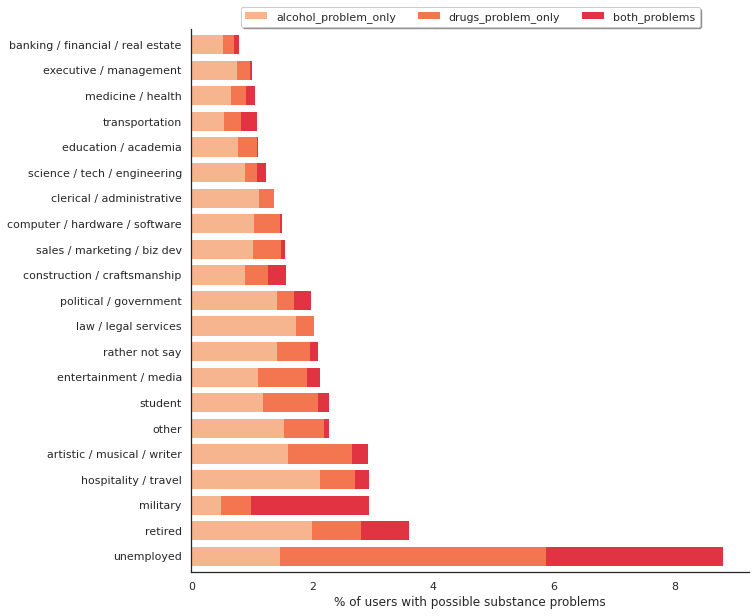

In [44]:

jobs_stacked = df.groupby("job").mean()[['alcohol_problem_only',
                                               'drugs_problem_only',
                                               'both_problems',
                                               'abuse']].sort_values('abuse')*100
jobs_stacked.drop('abuse', axis=1, inplace=True)
jobs_stacked.plot(kind='barh', stacked=True, figsize=(10,10), width=0.75, linewidth=0)
plt.ylabel("")
plt.xlabel("% of users with possible substance problems")
plt.gca().invert_yaxis()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
sns.despine()
plt.show()

### Question 2) Does having kids decrease the likelihood of substance abuse?


In [45]:
df['offspring'].isnull().mean()

0.5932172288392887

Whoever said that "doesn't have kids" (and might or might not want them), or simply "wants kids" will have the offspring variable set to zero, while everything else will be replaced with ones.

In [7]:
df.dropna(axis=0, subset=["offspring"], inplace=True)
df['offspring'].replace(['doesn&rsquo;t have kids',
                         'doesn&rsquo;t have kids, and doesn&rsquo;t want any',
                         'doesn&rsquo;t have kids, but might want them',
                         'doesn&rsquo;t have kids, but wants them',
                         'might want kids',
                         'doesn&rsquo;t want kids',
                         'wants kids'], 0, inplace=True)

df['offspring'].replace(['has a kid',
                         'has a kid, and might want more',
                         'has a kid, and wants more',
                         'has a kid, but doesn&rsquo;t want more',
                         'has kids',
                         'has kids, and might want more',
                         'has kids, and wants more',
                         'has kids, but doesn&rsquo;t want more',], 1, inplace=True)

## Identifying the good and bad variables

These are the available variables from the OkCupid data set:

- body_type
- diet
- drinks
- drugs
- education
- ethnicity
- height
- income
- job
- last_online
- location
- offspring
- orientation
- pets
- religion
- sex
- sign
- smokes
- speaks
- status
- essay from 0 to 9

First, let's drop all the columns we won't use. For the sake of simplicity, I won't use variables `essay[0-9]`. A future project might take these and apply some sort of sentiment analysis, for instance, but for now, I'll focus on categorical variables only. I'm also going to discard:

- last_online
- location
- sign
- speaks
- ethnicity
- height

In [5]:
df.drop(['last_online', 'location', 'sign', 'speaks', "ethnicity", "height"], axis=1, inplace=True)
df.drop([f"essay{n}" for n in np.arange(0,10)], axis=1, inplace=True)

## Transforming the diet variable

The "diet" variable has 6 possible values (anything, vegetarian, vegan, kosher, halal, and other) and 2 modifiers (mostly/strictly), which might create unnecessary dummy variables that won't add value to the model. So let's boil it down to diet type without the nuance.

In [6]:
df.dropna(axis=0, subset=['diet'], inplace=True)
df['vegetarian'] = df['diet'].apply(lambda x: 1 if ("vegetarian" in x) or ("vegan" in x) else 0)
df.drop("diet", axis=1, inplace=True)

## Interpreting users' religions

The `religion` variable has several possible values plus a few modifiers ("laughing about it, "somewhat serious about it", etc). I thought of creating a new variable out of these modifiers called `religious`, which is going to be 1 if `religion` is not atheism or agnosticism (for obvious reasons), and the `religion` modifier has the "very serious about it" modifier. 

In [20]:
df.dropna(axis=0, subset=["religion"], inplace=True)
df['religious'] = df['religion'].apply(lambda x: 1 if "very serious" in x else 0)
df['religious'] = ~df['religion'].isin(["agnosticism", "atheism"]) & df['religious'] == 1

df['religion'].replace([" and laughing about it",
                       " and somewhat serious about it",
                       " and very serious about it",
                       " but not too serious about it"], "", regex=True, inplace=True)

In [22]:
df[['religion', 'religious']]

,religion,religious
0,agnosticism,False
1,agnosticism,False
5,atheism,False
7,christianity,False
8,christianity,False
...,...,...
59934,judaism,False
59936,atheism,False
59942,agnosticism,False
59943,christianity,False


## Extract pet information

In [10]:
df['has_dogs'] = df['pets'].apply(lambda x: 1 if ("has dogs" in x) else 0)
df['has_cats'] = df['pets'].apply(lambda x: 1 if ("has cats" in x) else 0)
df['has_pets'] = df[['has_dogs', 'has_cats']].any(axis=1)
df.drop('pets', axis=1, inplace=True)

## Create dummy variables from categorical columns

### Does having kids decrease the likelihood of substance abuse?

In [40]:
df_kids = df_dummy[df_dummy["age"] >= 40].dropna(axis=0, subset=["offspring"])
kids = df_kids.groupby("offspring")["abuse"].mean().to_frame()

In [41]:
kids.rename_axis("has kids")

,abuse
has kids,
0,0.013881
1,0.008818


In [61]:
kids_cont = pd.crosstab(df_dummy['offspring'], df_dummy['abuse'],)
kids_cont

abuse,0,1
offspring,,
0,10928,307
1,2367,36


In [62]:
np.array(kids_cont)

array([[10928,   307],
       [ 2367,    36]])

In [63]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(kids_cont) # Print the p-value
print(p)

0.0005908269032632068


The p-value is 0.0006 which means that we reject the null hypothesis at 95% level of confidence. The null hypothesis was that Offspring and Abuse are independent.

In [18]:
# P(abuse = 1 | offspring = 1)
likelihood_abuse_T = df_kids[df_kids['abuse'] == 1]['offspring'].mean()*df_kids['abuse'].mean()
likelihood_abuse_F = df_kids[df_kids['abuse'] == 0]['offspring'].mean()*(1-df_kids['abuse'].mean())

likelihood_abuse_T/(likelihood_abuse_T + likelihood_abuse_F)

0.014981273408239699

In [19]:
# P(abuse = 1 | offspring = 0)
likelihood_abuse_T = (1-df_kids[df_kids['abuse'] == 1]['offspring'].mean())*df_kids['abuse'].mean()
likelihood_abuse_F = (1-df_kids[df_kids['abuse'] == 0]['offspring'].mean())*(1-df_kids['abuse'].mean())

likelihood_abuse_T/(likelihood_abuse_T + likelihood_abuse_F)

0.02732532265242546

## Stratify by age

In [20]:
df["age_group"] = pd.cut(df['age'], bins=[18,24,30,40,50,60,80])

### Does owning a pet help?

In [42]:
pets = df_dummy[df_dummy['age'] >= 40].groupby("has_pets")["abuse"].mean().to_frame()
pets

,abuse
has_pets,
False,0.009855
True,0.013855


In [46]:
religious = df_dummy[df_dummy['age'] >= 40].groupby("religious")["abuse"].mean().to_frame()

In [47]:
kids_plot = kids.rename(index={0: "no", 1: "yes"}).rename_axis("has kids")*100
pets_plot = pets.rename(index={False: "no", True: "yes"}).rename_axis("has pets")*100
religious_plot = religious.rename(index={False: "no", True: "yes"}).rename_axis("serious about religion")*100

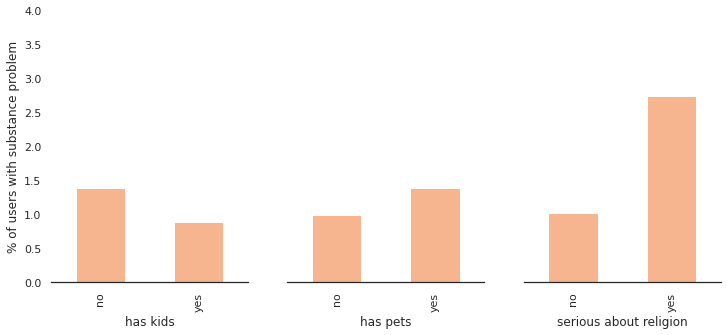

In [48]:
fig, axarr = plt.subplots(1, 3, figsize=(12, 5))
axarr[0].set_ylabel("% of users with substance problem")

axarr[0].set_ylim([0, 4])
axarr[1].set_ylim([0, 4])
axarr[2].set_ylim([0, 4])

kids_plot.plot.bar( ax=axarr[0] )
pets_plot.plot.bar( ax=axarr[1] )
religious_plot.plot.bar( ax=axarr[2] )

axarr[1].yaxis.set_visible(False)
axarr[2].yaxis.set_visible(False)

axarr[0].legend().set_visible(False)
axarr[1].legend().set_visible(False)
axarr[2].legend().set_visible(False)

sns.despine(left=True)

plt.show()

## Grouped by age

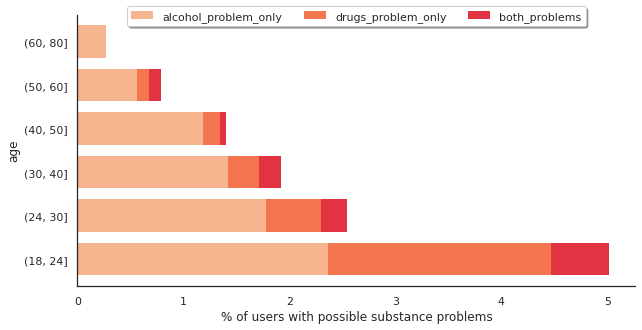

In [33]:
sns.set_style("white")

sns.set_palette("rocket_r")
sns.set_context("notebook")

age_group_stacked = df.groupby("age_group").mean()[['alcohol_problem_only',
                                               'drugs_problem_only',
                                               'both_problems',
                                               'abuse']].sort_values('abuse')*100
age_group_stacked.drop('abuse', axis=1, inplace=True)
age_group_stacked.plot(kind='barh', stacked=True, figsize=(10,5), width=0.75, linewidth=0)
plt.ylabel("age")
plt.xlabel("% of users with possible substance problems")
plt.gca().invert_yaxis()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
sns.despine()
plt.show()

### Substance problems grouped by religion

In [25]:
religion = df_dummy.groupby("religion")["abuse"].mean().sort_values().to_frame()
religion

,abuse
religion,
judaism,0.008979
christianity,0.012860
catholicism,0.017903
agnosticism,0.024503
other,0.026696
buddhism,0.028065
atheism,0.038092
hinduism,0.064000
islam,0.173913


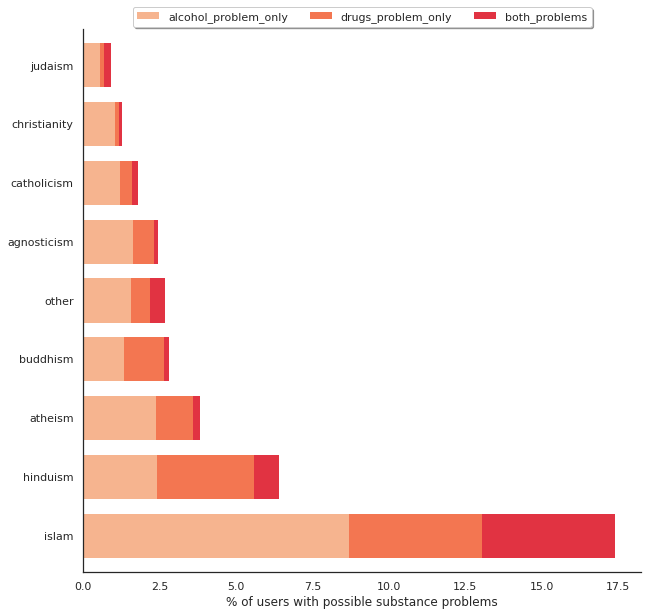

In [26]:
sns.set_style("white")

sns.set_palette("rocket_r")
sns.set_context("notebook")

religion_stacked = df_dummy.groupby("religion").mean()[['alcohol_problem_only',
                                               'drugs_problem_only',
                                               'both_problems',
                                               'abuse']].sort_values('abuse')*100
religion_stacked.drop('abuse', axis=1, inplace=True)
religion_stacked.plot(kind='barh', stacked=True, figsize=(10,10), width=0.75, linewidth=0)
plt.ylabel("")
plt.xlabel("% of users with possible substance problems")
plt.gca().invert_yaxis()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
sns.despine()
plt.show()

In [27]:
df_dummy.groupby("religious")["abuse"].mean().sort_values().to_frame()

,abuse
religious,
False,0.021947
True,0.071591


## Education

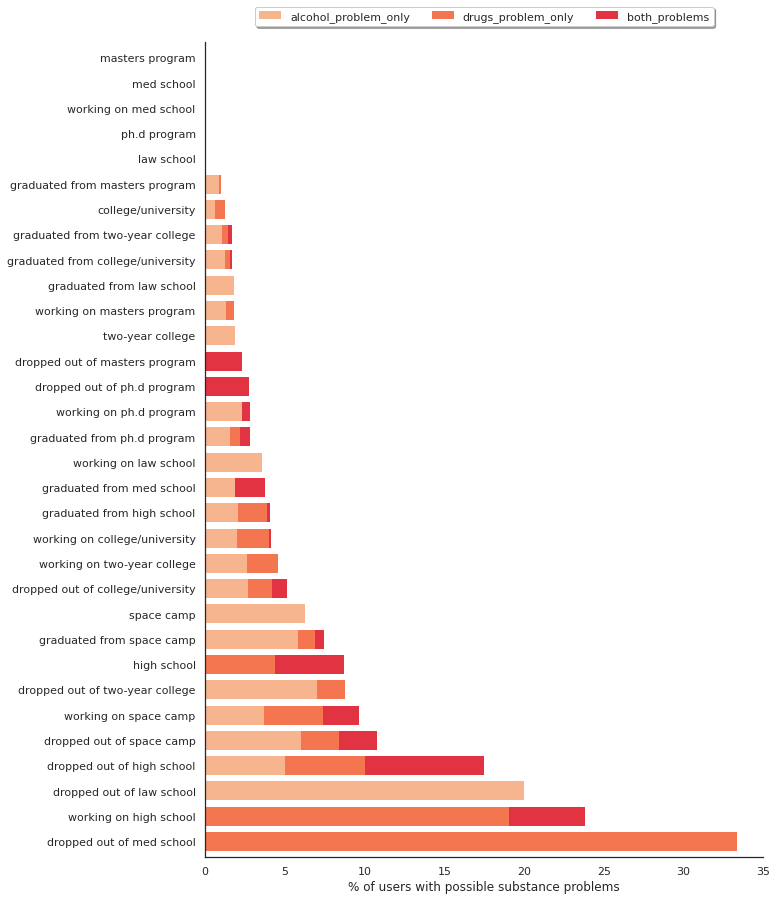

In [28]:
sns.set_style("white")

sns.set_palette("rocket_r")
sns.set_context("notebook")
education_stacked = df_dummy.groupby("education").mean()[['alcohol_problem_only',
                                               'drugs_problem_only',
                                               'both_problems',
                                               'abuse']].sort_values('abuse')*100
education_stacked.drop('abuse', axis=1, inplace=True)
education_stacked.plot(kind='barh', stacked=True, figsize=(10,15), width=0.75, linewidth=0)
plt.ylabel("")
plt.xlabel("% of users with possible substance problems")
plt.gca().invert_yaxis()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
sns.despine()
plt.show()

## Exploratory analysis

In [11]:
def create_dummy(df):
    """
    Creates dummy variables for all the categorial variables in a DataFrame and concatenates it
    with the original numerical columns.
    Input: pandas DataFrame
    Output: pandas DataFrame
    """
    cat_cols = df.select_dtypes(include="object").columns
    num_cols = df.select_dtypes(exclude="object").columns
    dummy_df = pd.get_dummies(df[cat_cols],
                              prefix=cat_cols,
                              prefix_sep="_",
                              dummy_na=True,
                              columns=cat_cols)
                              
    df_new = pd.concat([df[num_cols], dummy_df], axis=1)
    return df_new

In [12]:
df_dummy = pd.concat([create_dummy(df), df[['job', 'religion', 'status', 'education']], ], axis=1)

In [13]:
sns.set_theme(style="whitegrid")

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, roc_auc_score
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline

In [76]:
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))

y = df_dummy["abuse"]
X = df_dummy.drop("abuse", axis=1)
X.drop(['job',
        'religion',
        'status', 
        "has_pets",
        "alcohol_problem", 
        "drugs_problem",
        "both_problems",
        "alcohol_problem_only",
        "drugs_problem_only",
        "education"], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# concatenate our training data back together
X = pd.concat([pd.DataFrame(X_train), y_train], axis=1)

# separate minority and majority classes
not_abuse = X[X.abuse==0]
abuse = X[X.abuse==1]

# upsample minority
abuse_upsampled = resample(abuse,
                          replace=True, # sample with replacement
                          n_samples=len(not_abuse), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_abuse, abuse_upsampled])

y_train = upsampled.abuse
X_train = upsampled.drop('abuse', axis=1)

In [77]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=200))])

In [81]:
coef_table = pd.DataFrame(model.named_steps["logisticregression"].coef_[0], index=X_train.columns, columns=["coef"])

In [135]:
coef_table.sort_values("coef").tail(40)

,coef
job_unemployed,0.040878
status_available,0.042761
job_artistic / musical / writer,0.047561
religion_hinduism,0.049310
body_type_rather not say,0.050172
job_construction / craftsmanship,0.052299
education_college/university,0.052865
education_graduated from high school,0.054320
education_working on law school,0.063536
sex_m,0.064808


In [142]:
features = ["smokes_yes", "religious", "age", "job_unemployed",
           ]

In [143]:
model.fit(X_train[features], y_train)
precision_score(y_test, model.predict(X_test[features]))

0.050505050505050504

In [144]:
roc_auc_score(y_test, model.predict(X_test[features]))

0.6456858950287415